In [1]:
import os
import sys
import numpy as np
import torch, torchvision
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision.models as models
from skimage import io,transform
import nltk
import pickle
import argparse
from collections import Counter

In [2]:
mypath = '../../ml-a4-data/train_images/train_images'
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [3]:
len(onlyfiles)

29000

## build_vocab

In [4]:
class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [5]:
def build_vocab(all_captions, threshold):
    counter = Counter()
    
    # Generate the vocabulary
    wordbag = {'<UNK>','<PAD>','<START>','<END>'}
    
    for caption in (all_captions):
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        counter.update(tokens)

    # If the word frequency is less than 'threshold', then the word is discarded.
    words = [word for word, cnt in counter.items() if cnt >= threshold]

    # Create a vocab wrapper and add some special tokens.
    vocab = Vocabulary()
    vocab.add_word('<pad>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    vocab.add_word('<unk>')

    # Add the words to the vocabulary.
    for i, word in enumerate(words):
        vocab.add_word(word)
    return vocab

# Captions Processing

In [76]:
from build_vocab import Vocabulary
class CaptionsPreprocessing:
    """Preprocess the captions, generate vocabulary and convert words to tensor tokens

    Args:
        captions_file_path (string): captions tsv file path
    """
    def __init__(self, captions_file_path):
        self.all_captions = []
        
        self.captions_file_path = captions_file_path

        # Read raw captions
        self.raw_captions_dict = self.read_raw_captions()

        # Preprocess captions
        self.captions_dict = self.process_captions()

        # Create vocabulary
        self.vocab = self.generate_vocabulary()        

    def read_raw_captions(self):
        """
        Returns:
            Dictionary with raw captions list keyed by image ids (integers)
        """
        
        onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
        
        captions_dict = {}
        with open(self.captions_file_path, 'r', encoding='utf-8') as f:
            for img_caption_line in f.readlines():
                img_captions = img_caption_line.strip().split('\t')
                if(str('image_'+img_captions[0]+'.jpg') not in onlyfiles):
                    continue
                captions_dict[int(img_captions[0])] = img_captions[1:]

        return captions_dict

    def process_captions(self):
        """
        Use this function to generate dictionary and other preprocessing on captions
        """

        raw_captions_dict = self.raw_captions_dict

        # Do the preprocessing here
        for key in raw_captions_dict:
            raw_captions_dict[key] = [i[:-1] for i in raw_captions_dict[key]]
            self.all_captions += (raw_captions_dict[key])
            
        captions_dict = raw_captions_dict

        return captions_dict

    def generate_vocabulary(self):
        """
        Use this function to generate dictionary and other preprocessing on captions
        """

        captions_dict = self.captions_dict
        
        vocab = build_vocab(self.all_captions, 10);
        
        return vocab

    def captions_transform(self, img_caption_list):
        """
        Use this function to generate tensor tokens for the text captions
        Args:
            img_caption_list: List of captions for a particular image
        """
        tokens_list = [nltk.tokenize.word_tokenize(str(caption).lower()) for caption in img_caption_list]
        vocab = self.vocab
        
        res = []
        # Generate tensors
        for tokens in tokens_list:
            caption = []
            caption.append(vocab('<start>'))
            caption.extend([vocab(token) for token in tokens])
            caption.append(vocab('<end>'))
            target = torch.Tensor(caption)
            res.append(target)
        return (res)

# Set the captions tsv file path
CAPTIONS_FILE_PATH = '../../ml-a4-data/train_captions.tsv'
captions_preprocessing_obj = CaptionsPreprocessing(CAPTIONS_FILE_PATH)

In [77]:
ls = ['<start> Due ragazzi con i capelli ricci guardano le mani mentre sono in giardino <end>', '<start> Due giovani maschi bianchi sono fuori da molti cespugli <end>', '<start> Due uomini in magliette verdi sono in un cortile <end>', '<start> Un uomo in maglietta blu in giardino <end>', '<start> Due amici amano passare il tempo insieme <end>']
captions_preprocessing_obj.captions_transform(ls)

[tensor([ 1.,  3.,  3.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
         14., 15., 16.,  3.,  3.,  3.,  2.]),
 tensor([ 1.,  3.,  3.,  3.,  4., 17., 18., 19., 14., 20., 21., 22., 23.,  3.,
          3.,  3.,  2.]),
 tensor([ 1.,  3.,  3.,  3.,  4., 24., 15., 25., 26., 14., 15., 27., 28.,  3.,
          3.,  3.,  2.]),
 tensor([ 1.,  3.,  3.,  3., 27., 29., 15., 30., 31., 15., 16.,  3.,  3.,  3.,
          2.]),
 tensor([ 1.,  3.,  3.,  3.,  4., 32., 33., 34., 35., 36., 37.,  3.,  3.,  3.,
          2.])]

## Image Caption Dataset

In [21]:
class ImageCaptionsDataset:

    def __init__(self, img_dir, captions_dict, img_transform=None, captions_transform=None):
        """
        Args:
            img_dir (string): Directory with all the images.
            captions_dict: Dictionary with captions list keyed by image ids (integers)
            img_transform (callable, optional): Optional transform to be applied
                on the image sample.

            captions_transform: (callable, optional): Optional transform to be applied
                on the caption sample (list).
        """
        self.img_dir = img_dir
        self.captions_dict = captions_dict
        self.img_transform = img_transform
        self.captions_transform = captions_transform

        self.image_ids = list(captions_dict.keys())

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, 'image_{}.jpg'.format(self.image_ids[idx]))
        image = io.imread(img_name)
        captions = self.captions_dict[self.image_ids[idx]]

        if self.img_transform:
            image = self.img_transform(image)

        if self.captions_transform:
            captions = self.captions_transform(captions)

        sample = {'image': image, 'captions': captions}

        return sample

# Rescale

In [22]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, image):
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
        img = transform.resize(image, (new_h, new_w))
        return img


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, image):
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return image


IMAGE_RESIZE = (128, 128)
# Sequentially compose the transforms
img_transform = transforms.Compose([Rescale(IMAGE_RESIZE), ToTensor()])

In [78]:
IMAGE_DIR = '../../ml-a4-data/train_images/train_images'

In [79]:
train_dataset = ImageCaptionsDataset(
    IMAGE_DIR, captions_dict=captions_preprocessing_obj.captions_dict, img_transform=img_transform,
    captions_transform=captions_preprocessing_obj.captions_transform
)

In [80]:
train_dataset.__getitem__(1)['captions']

[tensor([ 1., 38., 24., 15., 39., 40., 41., 42., 27., 43., 44., 45.,  3.,  2.]),
 tensor([ 1.,  7., 46., 10., 47., 48., 27., 49., 45., 50.,  2.]),
 tensor([ 1.,  4., 24., 51., 52., 48., 53., 54., 51., 55., 56., 57.,  2.]),
 tensor([ 1., 58., 24., 15., 59., 60., 53., 61., 62.,  2.]),
 tensor([ 1., 63., 24., 48., 27., 64., 65.,  2.])]

In [69]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

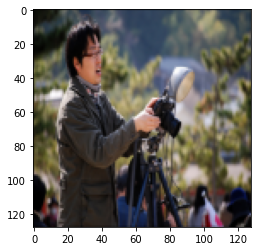

In [70]:
im = (train_dataset.__getitem__(4721)['image'])
im = im.transpose(1,2,0)
img = plt.imshow(im)

# Model Architecture

## EncoderCNN

In [23]:
class ImageCaptionsNet(nn.Module):
    def __init__(self, embed_size = 256):
        super(ImageCaptionsNet, self).__init__()

        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

    def forward(self, images):
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features

## DecodeRNN

In [100]:
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        print(captions)
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

# Train

In [25]:
# import argparse
import torch
import torch.nn as nn
import numpy as np
import os
import pickle
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import transforms

In [26]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [101]:
vocab = captions_preprocessing_obj.vocab
encoder = ImageCaptionsNet(256).to(device)
decoder = DecoderRNN(256, 512, len(vocab), 1).to(device)

In [102]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params, lr=0.001)

In [118]:
from torch.nn.utils.rnn import pad_sequence
a = (train_dataset[0]['captions'])
print(a)
torch.nn.utils.rnn.pad_sequence(a, batch_first=True)

[tensor([ 1.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16.,
         2.]), tensor([ 1.,  4., 17., 18., 19., 14., 20., 21., 22., 23.,  2.]), tensor([ 1.,  4., 24., 15., 25., 26., 14., 15., 27., 28.,  2.]), tensor([ 1., 27., 29., 15., 30., 31., 15., 16.,  2.]), tensor([ 1.,  4., 32., 33., 34., 35., 36., 37.,  2.])]


tensor([[ 1.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16.,
          2.],
        [ 1.,  4., 17., 18., 19., 14., 20., 21., 22., 23.,  2.,  0.,  0.,  0.,
          0.],
        [ 1.,  4., 24., 15., 25., 26., 14., 15., 27., 28.,  2.,  0.,  0.,  0.,
          0.],
        [ 1., 27., 29., 15., 30., 31., 15., 16.,  2.,  0.,  0.,  0.,  0.,  0.,
          0.],
        [ 1.,  4., 32., 33., 34., 35., 36., 37.,  2.,  0.,  0.,  0.,  0.,  0.,
          0.]])

In [117]:
# Train the models
total_step = len(train_dataset)
for epoch in range(5):
    for i, x in enumerate(train_dataset):
        images = (x['image'].repeat(5).reshape(5,3,128,128))
        captions = x['captions']
        # Set mini-batch dataset
        images = torch.Tensor(images).to(torch.float)
#         captions = (captions)
#         print(captions)
#         targets = torch.nn.utils.rnn.pad_sequence(captions, batch_first=True)
        targets = pack_padded_sequence(captions, torch.Tensor([len(x) for x in captions]), batch_first=True)
        # Forward, backward and optimize
        features = encoder(images)
        outputs = decoder(features, targets, torch.Tensor([len(x) for x in captions]))
        loss = criterion(outputs, targets)
        decoder.zero_grad()
        encoder.zero_grad()
        loss.backward()
        optimizer.step()

        # Print log info
        if i % args.log_step == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
                  .format(epoch, args.num_epochs, i, total_step, loss.item(), np.exp(loss.item()))) 

        # Save the model checkpoints
        if (i+1) % args.save_step == 0:
            torch.save(decoder.state_dict(), os.path.join(
                args.model_path, 'decoder-{}-{}.ckpt'.format(epoch+1, i+1)))
            torch.save(encoder.state_dict(), os.path.join(
                args.model_path, 'encoder-{}-{}.ckpt'.format(epoch+1, i+1)))

TypeError: _pack_padded_sequence(): argument 'input' (position 1) must be Tensor, not list